In [203]:
# Pipeline to compile and run experiemnts on test data
# 
# 0. Prepares test image frames and template
# 1. Runs PREPROCESS script to converts images into csv
# 2. compiles and runs detections on the test images:
#     e.g. g++ main.cpp Detector.cpp KalmanFilter.cpp Util.cpp  -std=c++2a && ./a.out ./data/test_data/ball/ output/ 8 20
# 3. Runs VISUALIZE  script to debug the detection/filtering results


In [214]:
# Visualizes an image (serized as csv) on subplot ax(i, j) with title
def show_im_fromcsv(csv_fn,  ax, i, j, title_str):
    import numpy as np 
    from matplotlib import pyplot as plt
    from PIL import Image
    import csv

    # reads RGB 3d image data from csv file
    with open(csv_fn,'r') as dest_f:
        data_iter = csv.reader(dest_f,
                               delimiter = ',',
                               quotechar = '"')
        data = [data for data in data_iter]
    n = int(data[0][0])
    m = int(data[0][1])
    k = int(data[0][2])
    np.testing.assert_equal(n*m*k, len(data[1]))

    # tranforms csv data into n x m x k (RGB image) matrix of integer
    data_array = np.asarray(data[1]).astype(int)
    data_array = np.reshape(data_array, [n, m, k], order='C') # AF

    # shows images
    if i < 0:
        plt.imshow(data_array, interpolation='nearest')
        plt.show()
    else:
        ax[i][j].imshow(data_array, interpolation='nearest')
        ax[i][j].set_title(title_str)

    # Log
    #     # shows image RGB values statistics as historgram
    #     d = data_array.ravel()
    #     plt.hist(d, bins=10)
    #     plt.show()




In [223]:
# Visualizes an gray image (serized as csv) on subplot ax(i, j) with title
def show_gray(csv_fn, threshold, ax, i, j, title_str):
    import numpy as np 
    from matplotlib import pyplot as plt
    from PIL import Image
    import csv
    
    # reads gray 2d matrix from csv file
    with open(csv_fn,'r') as dest_f:
        data_iter = csv.reader(dest_f,
                               delimiter = ',',
                               quotechar = '"')
        data = [data for data in data_iter]
    n = int(data[0][0])
    m = int(data[0][1])
    np.testing.assert_equal(n*m, len(data[1]))

    # tranforms csv data into n x m (gray image) matrix of float
    data_array = np.asarray(data[1]).astype(float)
    # (optional) thresholding, only show response >= threshold
    thresholding = False
    if threshold > 0:
        thresholding = True
    too_small = data_array < threshold
    if thresholding: 
        data_array[too_small] = 0;
    data_array = np.reshape(data_array, [n, m], order='C') # AF

    ax[i][j].imshow(data_array, interpolation='nearest')
    ax[i][j].set_title(title_str)


    # LOG
    # shows value statistics histofram of the gray response image
    #     stats = data_array.ravel()
    #     plt.hist(stats, bins=10)
    #     plt.show()



In [224]:
# Serializes an image into csv and writes in out_dir
def write_img2csv(img_dir, img_fn, out_dir):
    import numpy as np 
    from PIL import Image
    import csv
    
    # Open image from disk
    im = Image.open(img_dir + img_fn)
    na = np.array(im)

    sz = na.shape
    n = sz[0]
    m = sz[1]
    k = sz[2]
    a = [[],[]]
    a[0] = [n,m,k]
    a[1] = na.ravel()

    csv_fn = out_dir + img_fn + '.csv'
    with open(csv_fn, "w") as f:
        writer = csv.writer(f)
        writer.writerows(a)


In [225]:
# PREPROCESS

import os

# (REQUIRED) image names need to be in ascending order based on timestamp (01.jpg, 02.jpg, ...)

# pre-processes all images into csv files
base_dir =  'data/test_data/ball/'
out_dir = base_dir + 'csv/'
files = os.listdir(base_dir) 
i = 0
for f in files:
    if f.lower().endswith(('.png', '.jpg', '.jpeg')):
        write_img2csv(base_dir, f, out_dir)
        i = i + 1
print(' Converted '+ str(i) + ' images into csv at ' + out_dir)

# pre-processes all templates into csv files
base_dir_template = base + 'template/'
files = os.listdir(base_dir_template) 
for f in files:
    if f.lower().endswith(('.png', '.jpg', '.jpeg')):
        write_img2csv(base_dir_template, f, out_dir)
print(' Converted template ' + f + ' into csv at ' + out_dir)

 Converted 10 images into csv at data/test_data/ball/csv/
 Converted template 09.jpg.csv.template.csv into csv at data/test_data/ball/csv/


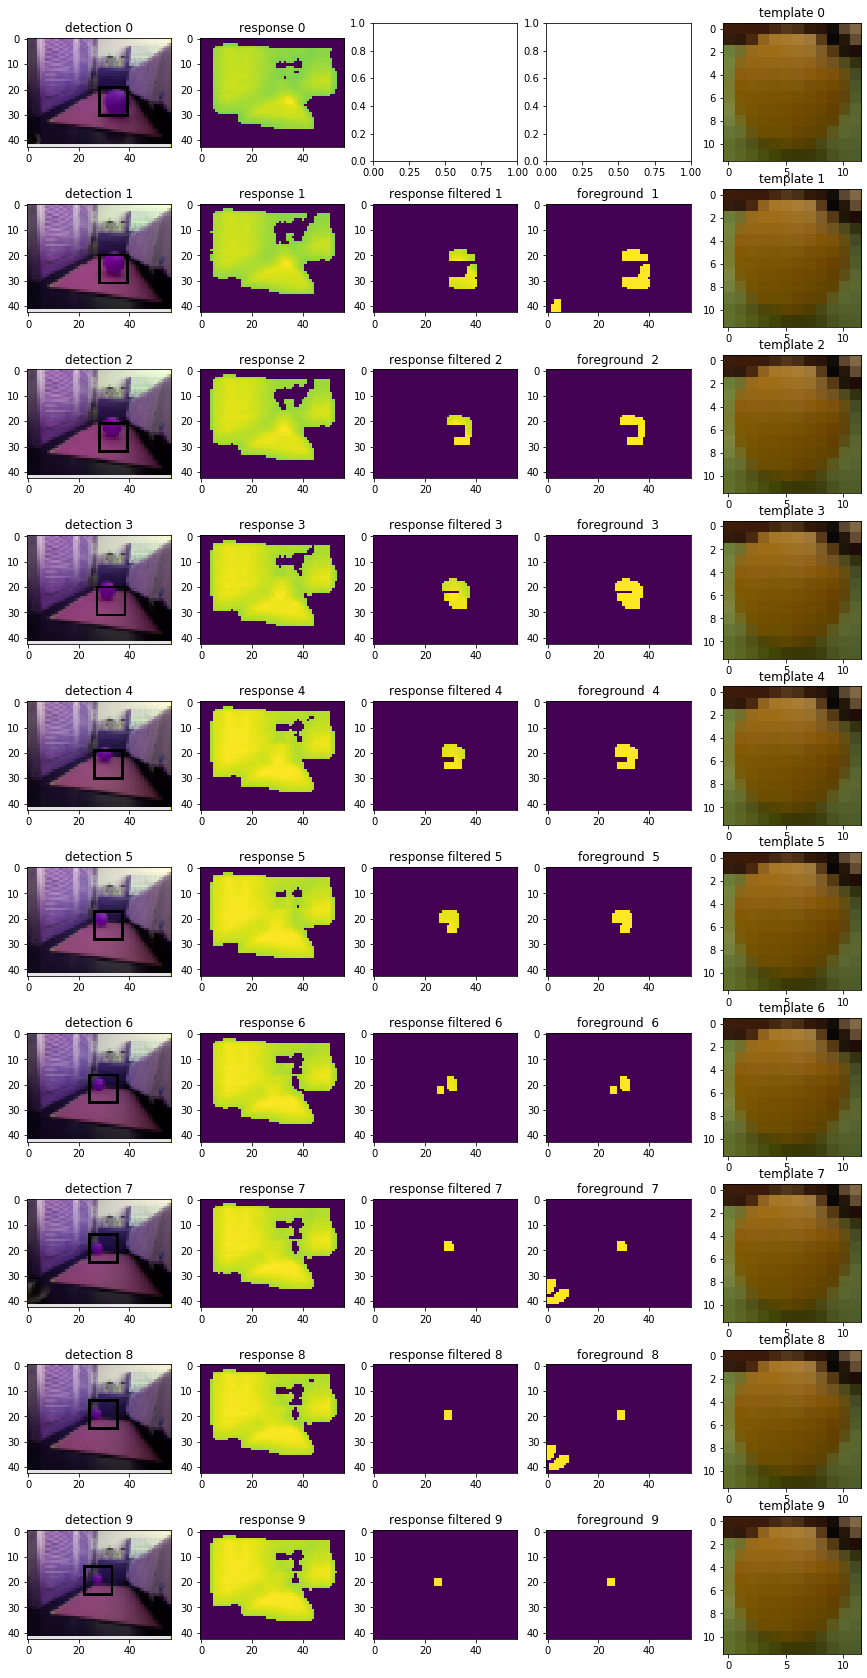

In [232]:
# VISUALIZE

from matplotlib import pyplot as plt

# test data image path
base_dir =  'data/test_data/ball/'
response_dir = base_dir + 'output1/'
num = 10  # the number of input image frames

        
# Visualizes each frame:
# 1 - detection bounding box
# 2 - convolution response
# 3 - filtered response
# 4 - foreground
# 5 - template
files = os.listdir(response_dir) 
files.sort()
fig,ax = plt.subplots(num, 5, figsize=(15,30))
i = 0
shown_1 = 0
shown_2 = 0
shown_3 = 0
shown_4  = 0

# (detection bounding box, convolution response, filtered response, foreground)
for f in files:
    i_str = str(i+1)
    if i < 9:
        i_str = '0' + i_str

    if f.lower().endswith(('.detection.jpg.csv')) and f.lower().startswith(i_str):
        show_im_fromcsv(response_dir + f, ax, i, 0, 'detection ' + str(i))
        shown_1 = 1

    if f.lower().endswith(('.response.csv')) and f.lower().startswith(i_str):
        show_gray(response_dir + f, 0.80, ax, i, 1, 'response ' + str(i))
        shown_2 = 1
    if i > 0 and f.lower().endswith(('.response_filtered.csv')) and f.lower().startswith(i_str):
        show_gray(response_dir + f, 0.80, ax, i, 2, 'response filtered ' + str(i))
        shown_3 = 1

    if i > 0 and f.lower().endswith(('.bg_mask.csv')) and f.lower().startswith(i_str):
        show_gray(response_dir + f, -1, ax, i, 3, 'foreground  ' + str(i))
        shown_4 = 1

    if i == 0 and shown_1 and shown_2:
        i = i + 1
        shown_1 = 0
        shown_2 = 0
        shown_3 = 0
        shown_4  = 0
    else:
        if shown_1 and shown_2 and shown_3 and shown_4:
            i = i + 1
            shown_1 = 0
            shown_2 = 0
            shown_3 = 0
            shown_4  = 0

# (template)
# Updated templates at each frame
# TODO(jifu) not implemented & fully tested yet
base_dir_template = base + 'template/'
files = os.listdir(base_dir_template) 
files.sort()
i = 0
for f in files:
    if f.lower().endswith(('template.csv')):
        show_im_fromcsv(base_dir_template + f, ax, i, 4, 'template '+str(i))
        i = i + 1


In [ ]:
# Visualizes detection traces (measurements) and corresponding estimated states (Kalman filtered)
files = os.listdir(response_dir) 
files.sort()
for f in files:
    if f.lower().endswith(('output.traces.jpg.csv')):
        show_im_fromcsv(response_dir + f, ax1, -1, -1, 'detection trace')